In [1]:
## importing the needed libraries 

# for the clustering models
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics

# to interpret clustering results 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit # gridsearch and train / test / validation split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler  
from sklearn.decomposition import PCA # to perfom PCA
from sklearn.preprocessing import OneHotEncoder # dummy coding 

In [ ]:
# reading the csv dataset
df_original = pd.read_csv("xxx")

## EDA

In [3]:
# extracting the needed columns to a seperate dataset 
df = df_original[['Age', 'Gender', 'Education_classes', 'Net_income_household', 'PoliticalSpectrum_Left']].copy()

In [4]:
# checking nulls and what type each column has 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2563 entries, 0 to 2562
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     2563 non-null   int64 
 1   Gender                  2563 non-null   object
 2   Education_classes       2563 non-null   object
 3   Net_income_household    2563 non-null   object
 4   PoliticalSpectrum_Left  2563 non-null   object
dtypes: int64(1), object(4)
memory usage: 100.2+ KB


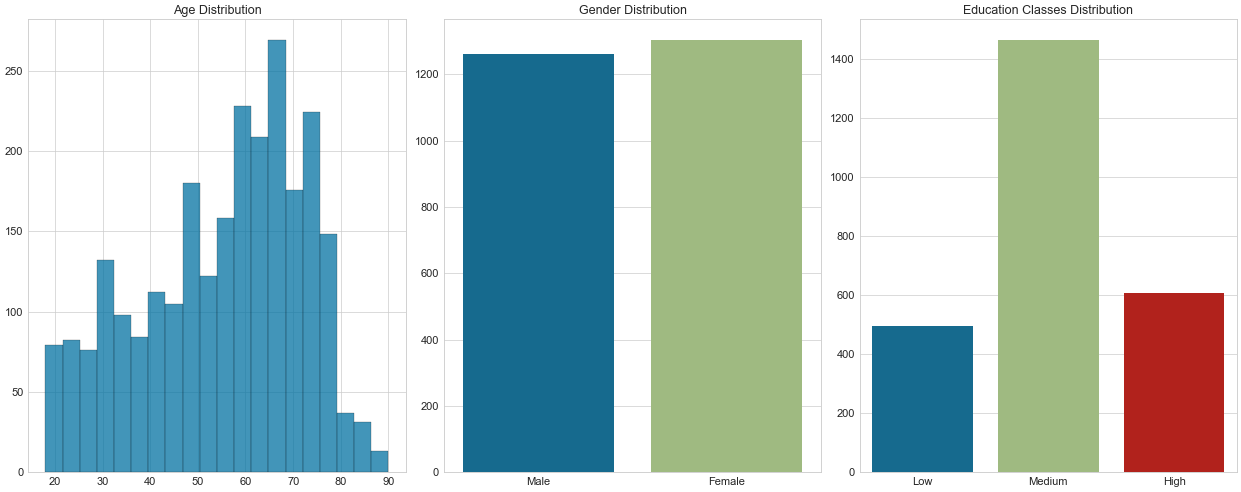

In [5]:
# Importing mplcursors

# Setting the figure size and dpi
fig = plt.figure(figsize=(25, 10), dpi=50)

# Defining the grid layout
grid = gridspec.GridSpec(1, 3)

# Defining the plot titles
plot_titles = [
    'Age Distribution',
    'Gender Distribution',
    'Education Classes Distribution',
]

# Defining the column names for each plot
plot_columns = [
    'Age',
    'Gender',
    'Education_classes',
]

# Iterating over the grid and creating the subplots
for i in range(grid.nrows * grid.ncols):
    ax = fig.add_subplot(grid[i])
    
    # Creating the plot based on the column name
    if i == 0:
        sns.histplot(data=df, x=plot_columns[i], ax=ax)
    else:
        sns.countplot(data=df, x=plot_columns[i], ax=ax)
    
    # Setting the plot title and adjusting font size
    ax.set_title(plot_titles[i], fontsize=18)
    
    # Removing axis labels
    ax.set(xlabel='', ylabel='')
    
    # Setting tick label font size
    ax.tick_params(axis='both', labelsize=16)
    
    # Enabling tooltips using mplcursors
    #mplcursors.cursor(ax)

plt.tight_layout()
plt.show()


The following conclusions can be drawn from the above graphs:
* It is evident that the majority of survey respondents fall within the age range of 60-70. This age group constitutes a significant portion of the participants.
* The gender distribution among the respondents appears to be relatively balanced, indicating a diverse representation in the survey.
* When examining the educational backgrounds of the participants, it is notable that the medium education class holds the highest number of respondents, approximately 1500 individuals. Additionally, the high and low education classes consist of 600 and 500 respondents respectively.

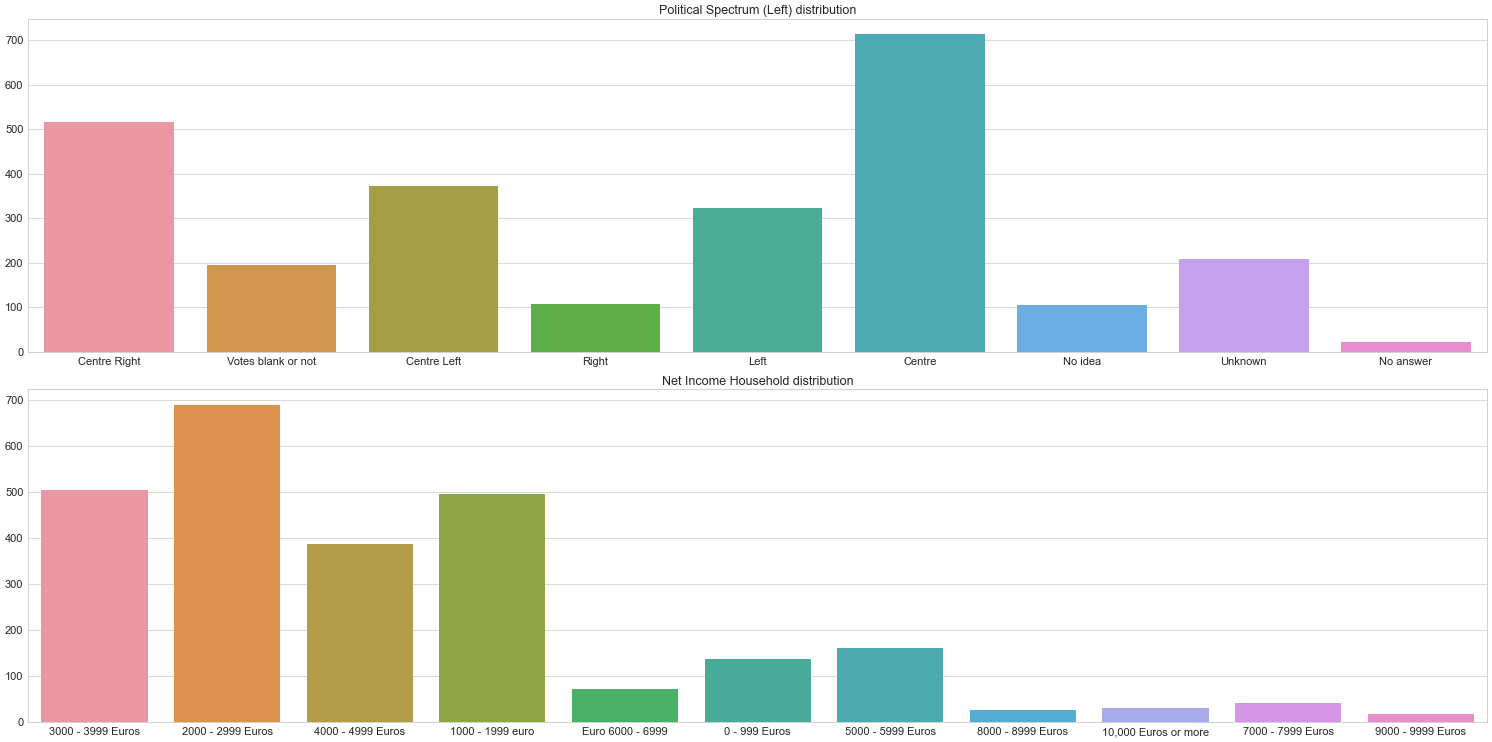

In [6]:
# Setting the figure size and dpi
fig = plt.figure(figsize=(30, 15), dpi=50)

# Defining the grid layout
grid = gridspec.GridSpec(2, 1)

# Adding subplots to the figure
ax4 = fig.add_subplot(grid[0, :])
ax5 = fig.add_subplot(grid[1, :])

# Creating a countplot for the 'PoliticalSpectrum_Left' column
sns.countplot(data=df, x='PoliticalSpectrum_Left', ax=ax4)
ax4.set_title('Political Spectrum (Left) distribution', fontsize=18)
ax4.tick_params(axis='both', labelsize=16)

# Creating a countplot for the 'Net_income_household' column
sns.countplot(data=df, x='Net_income_household', ax=ax5)
ax5.set_title('Net Income Household distribution', fontsize=18)
ax5.tick_params(axis='both', labelsize=16)

# Removing axis labels
for ax in [ax4, ax5]:
    ax.set(xlabel='', ylabel='')

plt.tight_layout()
plt.show()


The following conclusions can be drawn from the above graphs:
* A clear pattern emerges regarding the political spectrum preferences of the respondents. The majority, comprising around 700 individuals, position themselves in the center of the political spectrum. Additionally, approximately 500 respondents lean towards the center-right, while roughly 380 respondents identify with the center-left. Moreover, about 300 respondents express a preference towards the left, whereas approximately 100 respondents align themselves with the right.
* It is evident that the majority of the respondents fall within the income range of 1000 - 4999 EUR. However, the remaining income categories show a significantly lower number of respondents, with less than 200 individuals in each category.

To improve the data and achieve better balance, the following data transformations will be applied:

1) Converting the categories 'no idea', 'unknown', 'no answer', and 'votes blank or not' in the political spectrum column into 'other answer'.
2) Grouping together categories 'centre right' and 'right' in the political spectrum column into 'right'
3) Grouping together categories 'centre left' and 'left' in the political spectrum column into 'left'
4) Grouping the net income categories of 0-999 and 1000-1999 together.
5) Grouping all income categories above 5000 together.

In [7]:
# Displaying the value counts before the replacements
df['PoliticalSpectrum_Left'].value_counts().sort_values(ascending=False)

Centre                713
Centre Right          516
Centre Left           373
Left                  322
Unknown               209
Votes blank or not    196
Right                 108
No idea               105
No answer              21
Name: PoliticalSpectrum_Left, dtype: int64

In [8]:
## Combining "centre right" & "right", "centre left" & "left", and converting "unknown", "no idea", "no answer", "votes blank or not" into "other answer"
# Creating a dictionary to map the desired replacements
dict_left = {
    "Centre Right": "Right",
    "Right": "Right",
    "Centre Left": "Left",
    "Unknown": "Other",
    "Votes blank or not": "Other",
    "No idea": "Other",
    "No answer": "Other"
}

# Replacing the values in the 'PoliticalSpectrum_Left' column using the dictionary
df.replace({'PoliticalSpectrum_Left': dict_left}, inplace=True)

# Displaying the value counts after the replacements
df['PoliticalSpectrum_Left'].value_counts()

Centre    713
Left      695
Right     624
Other     531
Name: PoliticalSpectrum_Left, dtype: int64

In [9]:
# Displaying the value counts before the replacements
df['Net_income_household'].value_counts()

2000 - 2999 Euros       690
3000 - 3999 Euros       505
1000 - 1999 euro        496
4000 - 4999 Euros       387
5000 - 5999 Euros       162
0 - 999 Euros           137
Euro 6000 - 6999         71
7000 - 7999 Euros        41
10,000 Euros or more     31
8000 - 8999 Euros        26
9000 - 9999 Euros        17
Name: Net_income_household, dtype: int64

In [10]:
## Combining "0 - 999 Euros" & "1000 - 1999 euro", and converting all income levels above 5000 into one category
# Creating a dictionary to map the desired replacements
dict_income = {
    "0 - 999 Euros": "0 - 1999 Euro",
    "1000 - 1999 euro": "0 - 1999 Euro",
    "Euro 6000 - 6999": "5000 Euros or more",
    "7000 - 7999 Euros": "5000 Euros or more",
    "8000 - 8999 Euros": "5000 Euros or more",
    "9000 - 9999 Euros": "5000 Euros or more",
    "10,000 Euros or more": "5000 Euros or more",
    "5000 - 5999 Euros": "5000 Euros or more"
}

# Replacing the values in the 'Net_income_household' column using the dictionary
df.replace({'Net_income_household': dict_income}, inplace=True)

# Displaying the value counts after the replacements
df['Net_income_household'].value_counts()


2000 - 2999 Euros     690
0 - 1999 Euro         633
3000 - 3999 Euros     505
4000 - 4999 Euros     387
5000 Euros or more    348
Name: Net_income_household, dtype: int64

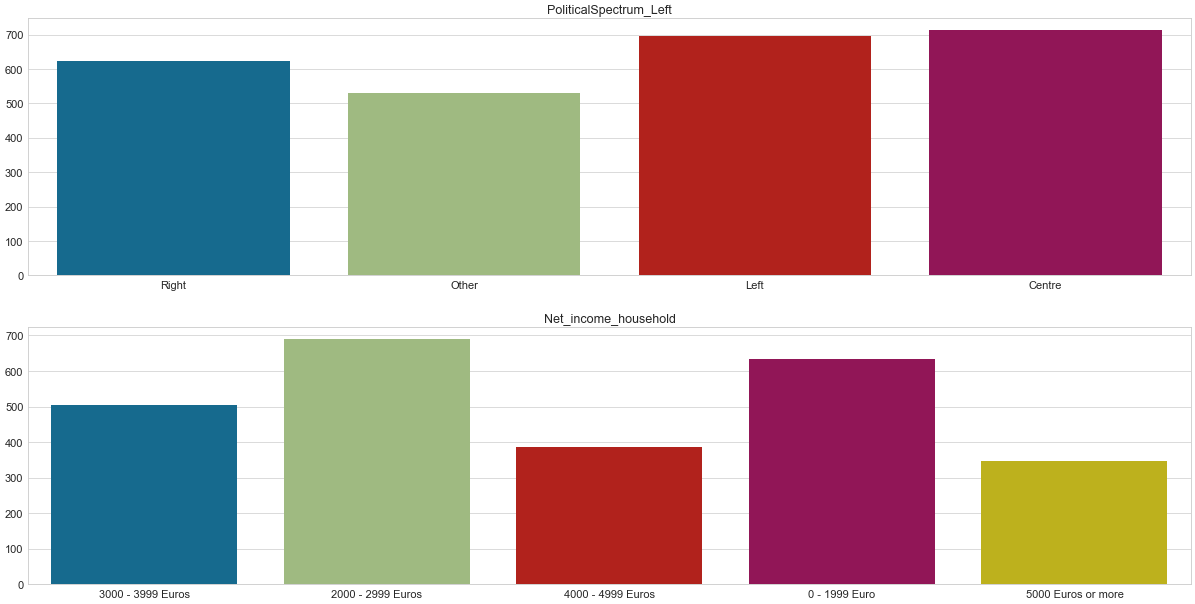

In [11]:
# Defining the grid layout with 2 rows and 1 column
grid = gridspec.GridSpec(2, 1)

# Setting the figure size and dpi
fig = plt.figure(figsize=(30, 15), dpi=50)

# Creating subplots in the specified grid positions
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[1, 0])

# Creating a countplot for 'PoliticalSpectrum_Left' column
sns.countplot(data=df, x='PoliticalSpectrum_Left', ax=ax1)
ax1.set_title('PoliticalSpectrum_Left', fontsize=18)
ax1.tick_params(axis='both', labelsize=16)

# Creating a countplot for 'Net_income_household' column
sns.countplot(data=df, x='Net_income_household', ax=ax2)
ax2.set_title('Net_income_household', fontsize=18)
ax2.tick_params(axis='both', labelsize=16)

# Removing axis labels for both subplots
for ax in [ax1, ax2]:
    ax.set(xlabel='', ylabel='')

Now the political spectrum column value counts range between 531 and 713 instead of the original range od 21 to 713 and the net income column between 348 and 690.

In [12]:
# Dummy coding the categorical features by creating dictionaries for mapping
dict_edu = {'Low': 0, 'Medium': 1, 'High': 2}
dict_gender = {'Female': 0, 'Male': 1}
dict_inc = {'0 - 1999 Euro': 0, '2000 - 2999 Euros': 1, '3000 - 3999 Euros': 2, '4000 - 4999 Euros': 3, '5000 Euros or more': 4}
dict_politics = {'Centre': 2, 'Left': 1, 'Right': 3, 'Other': 0}

# Replacing the categorical values with the encoded values using the dictionaries
df.replace({"Gender": dict_gender, 'Education_classes': dict_edu, 'Net_income_household': dict_inc, "PoliticalSpectrum_Left": dict_politics}, inplace=True)

# Displaying the first few rows of the modified dataframe
df.head()


,Age,Gender,Education_classes,Net_income_household,PoliticalSpectrum_Left
0,77,1,0,2,3
1,68,1,1,1,3
2,56,1,0,1,0
3,55,1,1,2,1
4,67,1,1,1,3


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2563 entries, 0 to 2562
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Age                     2563 non-null   int64
 1   Gender                  2563 non-null   int64
 2   Education_classes       2563 non-null   int64
 3   Net_income_household    2563 non-null   int64
 4   PoliticalSpectrum_Left  2563 non-null   int64
dtypes: int64(5)
memory usage: 100.2 KB


## PCA 
Principal Component Analysis (PCA) is a dimensionality reduction technique that aims to summarize the information contained in a dataset by transforming it into a new set of uncorrelated variables, called principal components. These components are ordered by the amount of variance they explain in the original data so principal component 1 captures the most variance.

By applying PCA to a dataset it will attempt to find linear combinations of the original columns (features) that explain most of the variance in the dataset. The result will be a set of new features, which are the principal components, and these new features will be uncorrelated with each other. 

Performing PCA on the dataset before feeding it into the k-means algorithm can improve clustering results by reducing noise, decreasing computation time, and mitigating the curse of dimensionality, while retaining the most important information in the data through principal components that capture the majority of the variance.

In [14]:
## Standardizing the dataset by feature scaling
# Defining standard scaler instance
scaler = StandardScaler() 
# Fitting the StandardScaler to df
scaler.fit(df)
# Creating the scaled df 
df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns)

df_scaled.shape

(2563, 5)

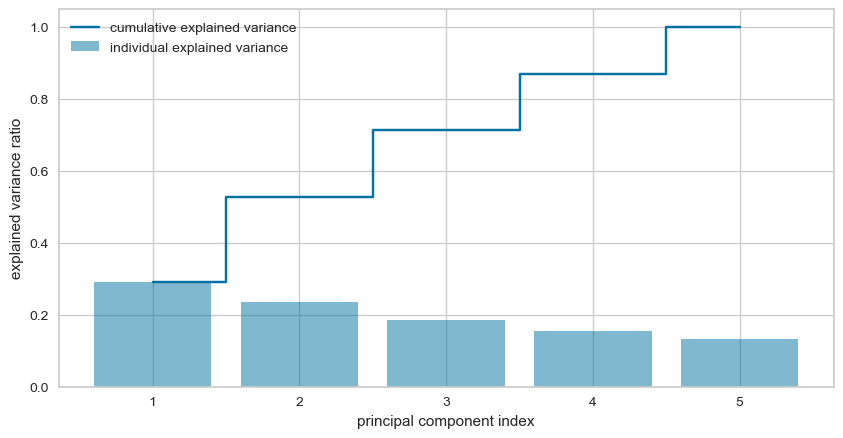

In [15]:
## PCA
pca = PCA()
# Finding pca components
pca_comps = pca.fit_transform(df_scaled)
# Finding how much each principal component explains the variance in the dataset
var_exp = pca.explained_variance_ratio_ 
# Finding the cumulative variance
cum_var_exp = np.cumsum(var_exp)

# Plotting the explained variance
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.bar(range(1,len(var_exp)+1), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,len(var_exp)+1), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('explained variance ratio')
plt.xlabel('principal component index')
plt.legend(loc='best')
plt.show()

In [16]:
var_exp_thres = 0.9 # I'd like to explain 90% variance
# calling pca instance 
pca = PCA(var_exp_thres) 
pca_comps = pca.fit_transform(df_scaled)
print('Number of components to explain {:0.0f}% varaince is {}'.format(var_exp_thres*100, pca.n_components_))

Number of components to explain 90% varaince is 5


## K-means 

Now as the optimal number of PC is determined (5) the reduced-dimensional data is fed into the k-means algorithm. K-means clustering partitions the data into k clusters, where k is a predefined number. The algorithm iteratively assigns data points to the nearest cluster centroid and updates the centroids until convergence.

c:\Users\elzad\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


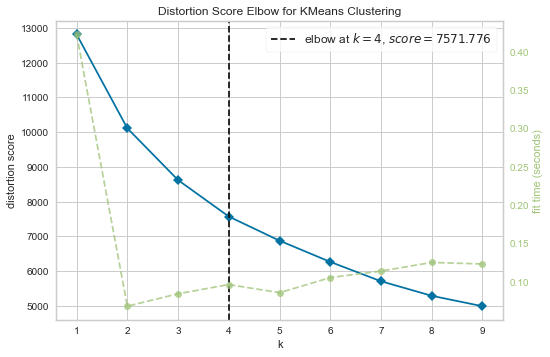

the best number of clusters k is: 4


In [17]:
## The elbow method to find the best k
# Creating the clustering model and visualizer
kmeans = KMeans(random_state=1234)
visualizer = KElbowVisualizer(kmeans, k=(1, 10))
visualizer.fit(pca_comps)
visualizer.show()
print('the best number of clusters k is:', visualizer.elbow_value_)

In [18]:
# Performing the final k-means on 4 clusters
kmeans_best_cluster = KMeans(n_clusters=visualizer.elbow_value_, random_state=1234)
kmeans_best_cluster.fit(pca_comps)
# Saving the cluster lables
cluster_labels_PCs = kmeans_best_cluster.labels_

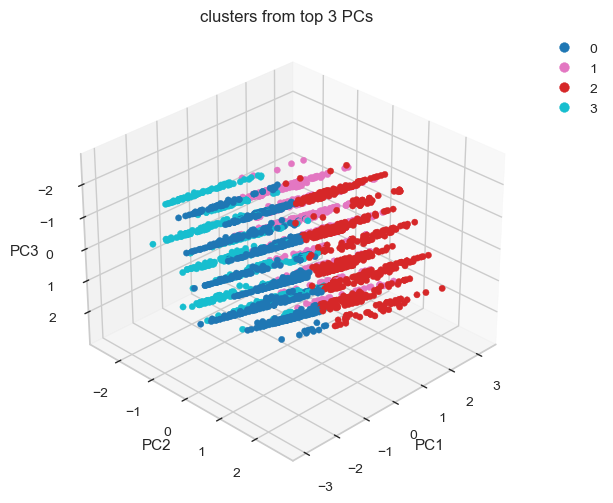

In [19]:
## Visualizing the clusters

# Getting a colormap from seaborn
cmap = ListedColormap(sns.color_palette('tab10', 200).as_hex())

# Setting up the graph
fig = plt.figure(figsize=(20, 7.5), dpi=100)

axes = fig.add_subplot(1, 3, 3, projection='3d')
sc = axes.scatter(pca_comps[:,0],pca_comps[:,1],pca_comps[:,2], c = cluster_labels_PCs, marker='o', cmap=cmap, alpha=1)
axes.set_xlabel('PC1')
axes.set_ylabel('PC2')
axes.set_zlabel('PC3')
axes.set_title('clusters from top 3 PCs')
axes.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2) 
axes.view_init(-150, -45) 

plt.show()

In [20]:
#Adding the clusters column to the original dataset
df_original['cluster'] = cluster_labels_PCs
df_original.head()

,StartDate,EndDate,Duration__in_seconds_,Finished,RecordedDate,ResponseId,Age,Age_classes,Gender,Party_to_vote_for,...,Type_of_house,Net_income_household,Postal_code,INHABITANTS_postal_cod,unemployment_socia_ass,share_owner_occupied_h,share_rented_house,Area_address_density,Urban_density_class,cluster
0,2021/11/12 12:41,2021/11/12 12:53,723,True,2021/11/12 12:53,R_7U1zhjT10Fj6Oyd,77,75+,Male,VVD,...,Owner-occupied house,3000 - 3999 Euros,1521,11305.0,10.747457,50.0,50.0,1700.0,Highly urban (address density of 1 500 to 2 500),3
1,2021/11/12 12:43,2021/11/12 13:11,1689,True,2021/11/12 13:11,R_2SfCEOKAWZpIB4U,68,65-75,Male,VVD,...,Owner-occupied house,2000 - 2999 Euros,1461,3630.0,4.683196,80.0,20.0,1061.0,Moderately urban (address density of 1 000 to ...,3
2,2021/11/12 12:43,2021/11/12 12:55,733,True,2021/11/12 12:55,R_XBTkVGK5l28mcZH,56,55-65,Male,Votes blank or not,...,Owner-occupied house,2000 - 2999 Euros,9403,14180.0,7.193230,80.0,20.0,1187.0,Moderately urban (address density of 1 000 to ...,3
3,2021/11/12 12:44,2021/11/12 13:06,1326,True,2021/11/12 13:06,R_12Sb67J1DHTIPPp,55,55-65,Male,PvdA (Labour Party),...,Owner-occupied house,3000 - 3999 Euros,6932,7425.0,10.303030,50.0,50.0,1228.0,Moderately urban (address density of 1 000 to ...,3
4,2021/11/12 12:44,2021/11/12 12:58,859,True,2021/11/12 12:58,R_3qtZ9hRp8cL0eSR,67,65-75,Male,VVD,...,Rented house,2000 - 2999 Euros,5235,6930.0,9.740260,60.0,40.0,1755.0,Highly urban (address density of 1 500 to 2 500),3


In [21]:
# reverting the dictionaries 

# dict_edu_rev = {key:value for key, value in zip(dict_edu.values(), dict_edu.keys())}
# dict_gender_rev = {key:value for key, value in zip(dict_gender.values(), dict_gender.keys())}
# dict_inc_rev = {key:value for key, value in zip(dict_inc.values(), dict_inc.keys())}
# dict_politics_rev = {key:value for key, value in zip(dict_politics.values(), dict_politics.keys())}

# df.replace({"Education_classes": dict_edu_rev}, inplace = True)
# df.replace({"Gender": dict_gender_rev}, inplace = True)
# df.replace({"Net_income_household": dict_inc_rev}, inplace = True)
# df.replace({"PoliticalSpectrum_Left": dict_politics_rev}, inplace = True)
# df.head()

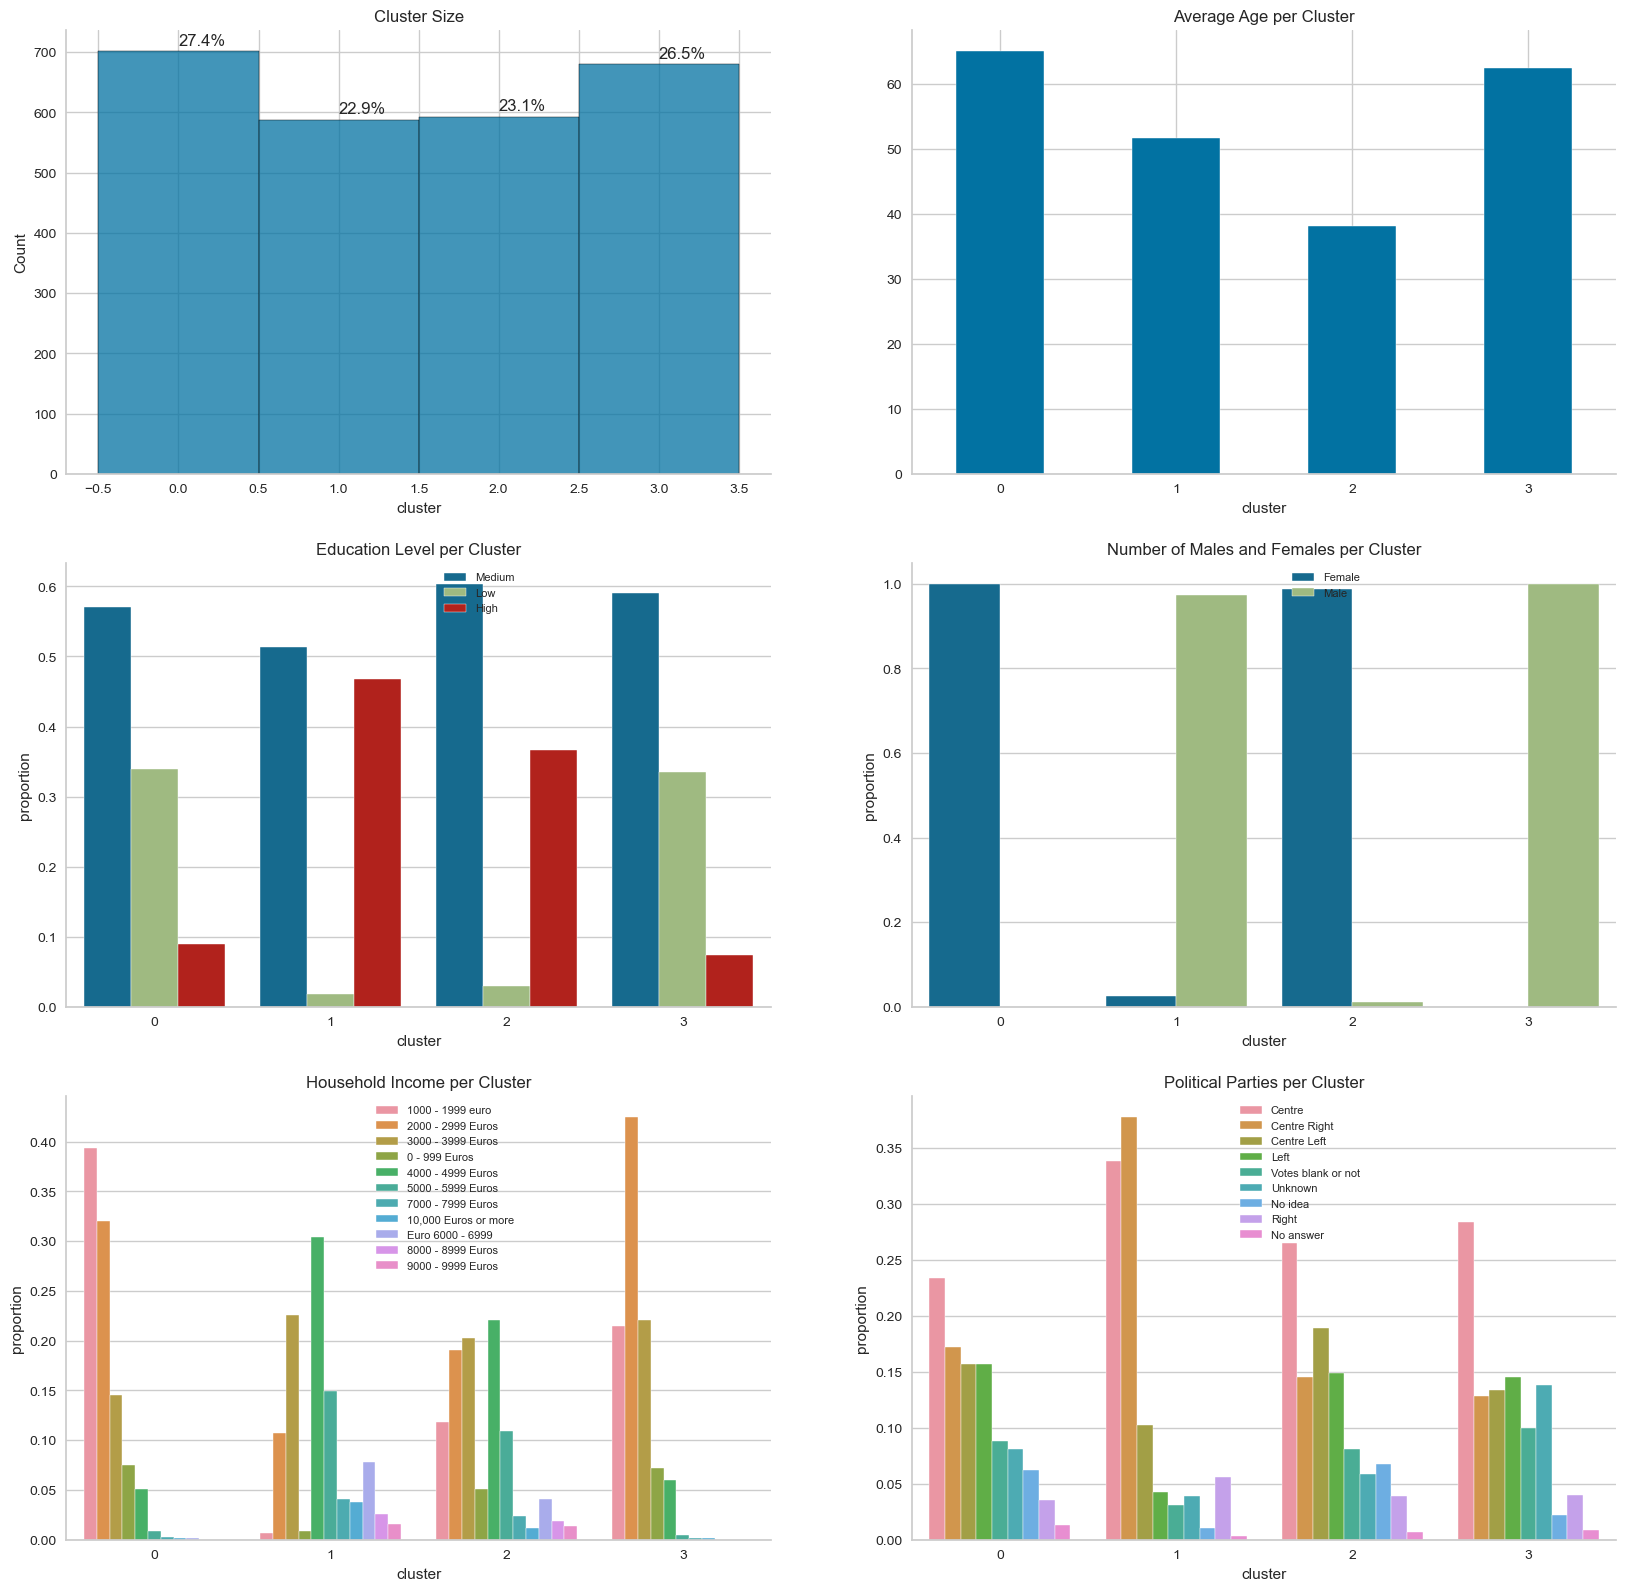

In [22]:
## Gaining insights from the 4 clusters through visualization

# Setting up the graphs
gs = gridspec.GridSpec(3, 2)
fig = plt.figure(figsize=(20, 20), dpi=100)

# Creating subplots for each graph
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Cluster Size')
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Average Age per Cluster')
ax3 = fig.add_subplot(gs[1, 0])
ax3.set_title('Education Level per Cluster')
ax4 = fig.add_subplot(gs[1, 1])
ax4.set_title('Number of Males and Females per Cluster')
ax5 = fig.add_subplot(gs[2, 0])
ax5.set_title('Household Income per Cluster')
ax6 = fig.add_subplot(gs[2, 1])
ax6.set_title('Political Parties per Cluster')

# Plotting cluster size
sns.histplot(data=df_original, x='cluster', discrete=True, ax=ax1)
for p in ax1.patches:
    ax1.annotate('{:.1f}%'.format((p.get_height() / len(df_original)) * 100), (p.get_x() + 0.5, p.get_height() + 10), fontsize=12)
sns.set_style("whitegrid")

# Plotting average age per cluster
age = df_original.groupby('cluster')['Age'].mean()
age.plot(kind='bar', rot=0, ax=ax2)
sns.set_style("whitegrid")

# Plotting education level per cluster
counted = df_original.groupby('cluster').Education_classes.value_counts(normalize=True).reset_index(name="proportion")
sns.barplot(data=counted, x='cluster', y='proportion', hue='Education_classes', ax=ax3)
ax3.legend(loc=1, bbox_to_anchor=(0.65, 1), fontsize=8)

# Plotting gender per cluster
counted = df_original.groupby('cluster').Gender.value_counts(normalize=True).reset_index(name="proportion")
sns.barplot(data=counted, x='cluster', y='proportion', hue='Gender', ax=ax4)
ax4.legend(loc=1, bbox_to_anchor=(0.65, 1), fontsize=8)

# Plotting household income per cluster
counted = df_original.groupby('cluster').Net_income_household.value_counts(normalize=True).reset_index(name="proportion")
sns.barplot(data=counted, x='cluster', y='proportion', hue='Net_income_household', ax=ax5)
ax5.legend(loc=1, bbox_to_anchor=(0.65, 1), fontsize=8)

# Plotting political parties per cluster
counted = df_original.groupby('cluster').PoliticalSpectrum_Left.value_counts(normalize=True).reset_index(name="proportion")
sns.barplot(data=counted, x='cluster', y='proportion', hue='PoliticalSpectrum_Left', ax=ax6)
ax6.legend(loc=1, bbox_to_anchor=(0.65, 1), fontsize=8)

# Removing the top and right spines for a cleaner look
sns.despine()


Here are some conlusions that can be drawn from the above graphs:
* Cluster 1 is the largest cluster, with an average respondent age of approximately 65, making it the oldest cluster. All respondents in this cluster are female, and most have a medium education level. However, it also has the highest number of low education respondents. The majority of respondents in this cluster earn between 1,000 to 2,999 EUR. This cluster contains the highest number of respondents who identify with the left political party. 
* Cluster 2 is the smallest cluster, primarily consisting of males with an average age of approximately 52. This cluster has the highest number of respondents with high education and the lowest number of respondents with low and medium education. Most respondents in this cluster earn between 3,000 and 4,999 EUR, and it also contains the highest number of respondents in the 10,000 EUR or more income group. This cluster has the highest number of respondents associated with the center-right, center, and right political parties.
* Cluster 3 is the second smallest cluster, with an average respondent age of approximately 38, making it the youngest cluster. It is predominantly composed of females with mostly medium and high education levels. Notably, this cluster has the highest number of respondents in the medium education level. The majority of respondents in this cluster earn between 2,000 and 4,999 EUR and are associated with the center-right political party.
* Cluster 4 is the second largest cluster, exclusively consisting of male respondents with an average age of approximately 62. Most respondents in this cluster have either medium or low education levels, and it has the smallest number of high education level respondents. The majority of respondents in this cluster fall within the 2,000-2,999 income group and are primarily associated with the center political party.

These clusters were summarized into 4 personas that can be found in [this](https://public.tableau.com/app/profile/cmihva/viz/FromFossilFoolToGreenBeanWhatCanTheDutchiesDo/Stimulating-Sustainability-among-Dutch-Consumers) visualisation. 